<a href="https://colab.research.google.com/github/H40Q1/523_stock_predict/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EC523 Project : Stock Price Prediction

##  0. Import Libraries

In [ ]:
!pip3 install pytorch-nlp
import pandas as pd
import numpy as np
import os
import sys
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchnlp.nn as nlpnn

     |████████████████████████████████| 92kB 7.4MB/s 


##  1. Data Preprocess

First of all, let's read the data set file and take a look of it.

In [ ]:
# path = "/content/stock_data.csv"
path = "/content/AAPL.csv"
stock_dataset =  pd.read_csv(path, header=0)

Let's take a look of first 5 rows of data set.

In [ ]:
stock_dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [ ]:
stock_dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1.980000e+03
mean,112.285808,113.508752,111.011495,112.312207,112.312207,3.301999e+07
std,58.080987,58.584028,57.575041,58.133793,58.133793,2.959716e+07
min,18.080000,18.270000,17.549999,17.730000,17.730000,5.913100e+06
25%,64.647497,65.575001,63.817501,64.762499,64.762499,1.616085e+07
50%,113.810001,114.654999,112.945000,113.810001,113.810001,2.405750e+07
75%,167.852505,169.492496,166.022499,168.085003,168.085003,3.986862e+07
max,222.570007,224.199997,221.279999,223.229996,223.229996,5.735764e+08


What is the exact length of each column?

In [ ]:
open_price = stock_dataset.Open.values.astype('float32')
open_price = open_price.reshape(-1, 1)
print(open_price.shape[0])

9909


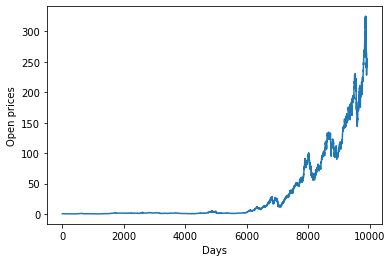

In [ ]:
plt.plot(open_price)
plt.ylabel("Open prices")
plt.xlabel("Days")
plt.show()

Here is the class of parameters of this project:

In [ ]:
class Config:
    
    # feature_columns = list(range(2, 9))     # feature columns' indecies 
    feature_columns = list(range(1, 7))
    # label_columns = [2,3]                # predicted feature columns' indecies
    label_columns = [1,4]  
    label_in_feature_index = (lambda x,y: [x.index(i) for i in y])(feature_columns, label_columns)  
    
    predict_day = 1             # predited length (days)
    
    input_size = len(feature_columns)
    output_size = len(label_columns)

    hidden_size = 128           # hiddent size
    lstm_layers = 2             # stacked layer number
    dropout_rate = 0.2          # dropout
    time_step = 20              # step size (day)
    epoch = 50
    epoch_attention = 50
    
#     do_train = True
#     do_predict = True
#     shuffle_train_data = True           

    train_data_rate = 0.7    
    valid_data_rate = 0.075   
    test_data_rate = 0.075

    batch_size = 64
    learning_rate = 0.0001

    use_cuda = False
    # path
    used_frame = "pytorch"
    model_name = "model_" + ".pth"
    # train_data_path = "/content/stock_data.csv"
    train_data_path = "/content/AAPL.csv"
    model_save_path = "./checkpoint/" + used_frame + "/"
    

    # save 
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)    


Class of dataset process and split.

In [ ]:
class Data:
    def __init__(self, config):
        self.config = config
        self.data, self.data_column_name = self.read_data()
        self.data = np.array(self.data, dtype=np.float64)
        self.data_num = self.data.shape[0]
        ### interval of dataset
        # x_train [0:s]
        # y_train [d:s+d]
        # x_valid [s:v]
        # y_valid [s+d:v+d]
        # x_test [v:-d]
        # y_test [v+d:-1]

        self.train_num = int(self.data_num * self.config.train_data_rate)   #  self.train_num = s
        
        self.valid_num = int(self.train_num + self.data_num * self.config.valid_data_rate)  # self.valid_num = v

        self.test_num = int(self.valid_num + self.data_num * self.config.test_data_rate)

        self.mean = np.mean(self.data, axis=0)              # mean and std
        self.std = np.std(self.data, axis=0)
        self.norm_data = (self.data - self.mean)/self.std   # normalization


    def read_data(self):                # read data
        init_data = pd.read_csv(self.config.train_data_path, usecols=self.config.feature_columns)
        
        
        return init_data.values, init_data.columns.tolist()     

    
    def get_train_data(self):
        feature_data = self.norm_data[:self.train_num]  # interval [0:s]  
        
        # interval [d:s+d]  
        label_data = self.norm_data[self.config.predict_day : self.config.predict_day + self.train_num,
                                    self.config.label_in_feature_index]    

        train_x = [feature_data[i:i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
        train_y = [label_data[i:i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
        

        train_x, train_y = np.array(train_x), np.array(train_y)

        return train_x, train_y
    
    def get_valid_data(self):
        
        feature_data = self.norm_data[self.train_num : self.valid_num]  
        # interval [s:v]  
        
        # interval [s+d:v+d]  
        label_data = self.norm_data[self.config.predict_day + self.train_num : self.config.predict_day + self.valid_num,
                                    self.config.label_in_feature_index]    # create label
        
        
        valid_x = [feature_data[i:i+self.config.time_step] for i in range(self.valid_num-self.train_num-self.config.time_step)]
        valid_y = [label_data[i:i+self.config.time_step] for i in range(self.valid_num-self.train_num-self.config.time_step)]

   
        valid_x, valid_y = np.array(valid_x), np.array(valid_y)

        return valid_x, valid_y


    def get_test_data(self):
        
        feature_data = self.norm_data[self.valid_num : self.test_num]
        # feature interval[v:-d]
        
        test_x = [feature_data[i:i+self.config.time_step] for i in range(self.test_num - self.valid_num - self.config.time_step-1)]

        test_x = np.array(test_x)
        
        return test_x
    
    
    def return_label(self, dataset):
        
        if dataset =="train":
            label_data = self.data[self.config.time_step :self.train_num ,
                                            self.config.label_in_feature_index]
        elif dataset == "valid":
            label_data = self.data[self.train_num+self.config.time_step :self.valid_num ,
                                            self.config.label_in_feature_index]
        else:
            label_data = self.data[self.valid_num+self.config.time_step :self.test_num - self.config.predict_day ,
                                            self.config.label_in_feature_index]
            
            
        return label_data
            
        
        

In [ ]:
config = Config()
data_gainer = Data(config)
train_x, train_y = data_gainer.get_train_data()
valid_x, valid_y = data_gainer.get_valid_data()
test_x= data_gainer.get_test_data()
train_label = data_gainer.return_label("train")
valid_label = data_gainer.return_label("valid")
test_label = data_gainer.return_label("test")

# train_y, valid_y, test_y = train_y.reshape(), valid_y, test_y 

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)
print(len(train_label))
print(len(valid_label))
print(len(test_label))
# print(test_y.shape)

(4256, 20, 7)
(4256, 20, 2)
(438, 20, 7)
(438, 20, 2)
(437, 20, 7)
4256
438
437


## 2. Network and Training Preview

Current net is a stacked LSTM, we are going to modify it later on 

In [ ]:
class Net(Module):
    def __init__(self, config, attention_net=False):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=config.input_size, hidden_size=config.hidden_size,
                            num_layers=config.lstm_layers, batch_first=True,
                            dropout=config.dropout_rate)
        self.attention = nlpnn.Attention(config.hidden_size)
        self.attention_linear = nn.Linear(in_features=config.hidden_size, out_features=config.hidden_size)
        self.linear = nn.Linear(in_features=config.hidden_size, out_features=config.output_size)
        self.hidden_size = config.hidden_size  # 128
        self.time_step = config.time_step      # 20
        self.attention_net = attention_net     # True: attention layer
        
    def forward(self, x, hidden=None):
        lstm_out, hidden = self.lstm(x, hidden)
        y = 0
        if self.attention_net:
            query = self.attention_linear(torch.ones(x.shape[0], self.time_step, self.hidden_size))
            attention_out, _ = self.attention(query, lstm_out)
            y = self.linear(attention_out)
        else:
            y = self.linear(lstm_out)
        return y, hidden

In [ ]:
def train(x_train, y_train, config, attention_net=False):
    print("Start training ...")
    device = torch.device("cuda:0" if config.use_cuda and torch.cuda.is_available() else "cpu")
    net = Net(config, attention_net).to(device)

    train_x, train_y = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()
    train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size = config.batch_size)

    # totally s iterations
#     s = train_x.shape[0]

    if not attention_net:
        epoches = config.epoch
    else:
        epoches = config.epoch_attention

    optimizer = optim.Adam(net.parameters(), lr=config.learning_rate)
    criterion = nn.MSELoss()
    losses = []  # store losses of each iteration
    epc_mean = []  # store mean losses of each epoch
    for epoch in range(epoches):
        epoch_loss = []
        hidden = None
        for i, data in enumerate(train_loader):
            train_x, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            y_pred, hidden = net.forward(train_x, hidden)
#             h_t, c_t = hidden
#             h_t.detach_(), c_t.detach_()
#             hidden = (h_t, c_t)
            hidden = None
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            epoch_loss.append(loss.item())
        cur_loss = np.mean(np.array(epoch_loss))
        if cur_loss < 0.00017:
            break
        print("Epoch {}/{}".format(epoch+1, config.epoch), " Train Loss :{}".format(cur_loss))
        epc_mean.append(cur_loss)
        
    
    torch.save(net.state_dict(), config.model_save_path + config.model_name)
    print('Finished Training Trainset')
    print('Net parameters are saved at {}'.format(config.model_save_path + config.model_name))
    return losses, epc_mean


def loss_plot(losses):
    plt.plot(losses) 
    plt.xlabel('epoch') 
    plt.ylabel('training loss') 
    plt.title('Training Loss history') 
    plt.show()


In [ ]:
_, loss_mean= train(train_x, train_y, config)

Start training ...
Epoch 1/50  Train Loss :0.9760243572405914
Epoch 2/50  Train Loss :0.7088566961239523
Epoch 3/50  Train Loss :0.4635236931255838
Epoch 4/50  Train Loss :0.32610140029869195
Epoch 5/50  Train Loss :0.20455846967481411
Epoch 6/50  Train Loss :0.1783316400138411
Epoch 7/50  Train Loss :0.15931428956743607
Epoch 8/50  Train Loss :0.14113848363813847
Epoch 9/50  Train Loss :0.12475197331340455
Epoch 10/50  Train Loss :0.10995914327647927
Epoch 11/50  Train Loss :0.09713088715476777
Epoch 12/50  Train Loss :0.08728198912481207
Epoch 13/50  Train Loss :0.07952881237116656
Epoch 14/50  Train Loss :0.07378170340071752
Epoch 15/50  Train Loss :0.07027374235426646
Epoch 16/50  Train Loss :0.06755794896466184
Epoch 17/50  Train Loss :0.08541319967219745
Epoch 18/50  Train Loss :0.10773991724587421
Epoch 19/50  Train Loss :0.1298476983515073
Epoch 20/50  Train Loss :0.05982408739987816
Epoch 21/50  Train Loss :0.05664839120164736
Epoch 22/50  Train Loss :0.05138427607798532
Epoch

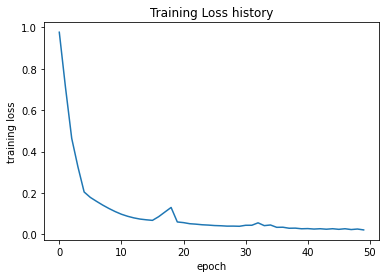

In [ ]:
loss_plot(loss_mean)

In [ ]:
def predict(x_test, config, attention_net=False):
    device = torch.device("cuda:0" if config.use_cuda and torch.cuda.is_available() else "cpu")
    y_pred = torch.empty((0, len(config.label_columns))).to(device)
    y_hat = []
    test_X = torch.from_numpy(x_test).float()
    test_set = TensorDataset(test_X)
    test_loader = DataLoader(test_set, batch_size=1)

    
    net = Net(config, attention_net).to(device)
    net.load_state_dict(torch.load(config.model_save_path + config.model_name))
    net.eval()
    hidden = None
    for data in test_loader:
        tmp = []
        x = data[0].to(device)
        y, hidden = net.forward(x, hidden)
        hidden = None
#         y_pred_0 = torch.cat((y_pred, y[0]), 0)
        tmp.append(y[0][-1][0].item())
        tmp.append(y[0][-1][1].item())
        y_hat.append(tmp)
    return np.array(y_hat)


def up_down_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result


def evaluate(y_pred, y_test, data_gainer, days=300):
    labels_open = []
    labels_close = []
    for i in range(y_test.shape[0]):
        labels_open.append(y_test[i][0])
    for i in range(y_test.shape[0]):
        labels_close.append(y_test[i][1])
    
    
    
    print("###############################################################")
    print("Evaluation of open price predction on test set:")
    
    y_pred_0 = y_pred[:,0] * data_gainer.std[0] + data_gainer.mean[0]
    
    
    # Error comptuer of open price prediction
    #Root Mean Square Error
    RMSE = np.sqrt(np.sum((np.array(labels_open) - y_pred_0) ** 2) / len(labels_open)) 
    # Mean Absolute Percentage Error
    MAPE = np.sum((np.array(labels_open) - y_pred_0)/np.array(labels_open))/len(labels_open)*100 
    # Mean Bias Error
    MBE = np.sum((np.array(labels_open) - y_pred_0)) / len(labels_open)
    print("RMSE on validation set is {}".format(RMSE))
    print("MAPE on validation set is {}".format(MAPE))
    print("MBE on validation set is {}".format(MBE))    
    up_down_accu = up_down_accuracy(labels_open, y_pred_0)
    print("Up and down accuracy on validation set is {}%".format(round(up_down_accu*100),2))


    plt.xlabel('Days') 
    plt.ylabel('Price') 
    plt.title('Evaluation of Open prices on test set for 130 days') 
    plt.plot(y_pred_0.tolist()[:days], 'r', label = "predict")
    plt.plot(labels_open[:days], 'b', label = "real")
    plt.legend(loc="upper right")
    plt.show()
    
    
    # Error comptuer of close price prediction

    print("###############################################################")
    print("Evaluation of close price predction on valid set:")
    y_pred_1 = y_pred[:,1] * data_gainer.std[1] + data_gainer.mean[1]
    
    
    # Error comptuer of open price prediction
    # Root Mean Square Error
    RMSE = np.sqrt(np.sum((np.array(labels_close) - y_pred_1) ** 2) / len(labels_close)) 
    # Mean Absolute Percentage Error
    MAPE = np.sum((np.array(labels_close) - y_pred_1)/np.array(labels_close))/len(labels_close)*100 
    # Mean Bias Error
    MBE = np.sum((np.array(labels_close) - y_pred_1)) / len(labels_close)
    print("RMSE on validation set is {}".format(RMSE))
    print("MAPE on validation set is {}%".format(MAPE))
    print("MBE on validation set is {}".format(MBE))    
    up_down_accu = up_down_accuracy(labels_close, y_pred_1)
    print("Up and down accuracy on validation set is {}%".format(round(up_down_accu*100),2))


    plt.xlabel('Days') 
    plt.ylabel('Price') 
    plt.title('Evaluation of Close prices on test set for 130 days') 
    plt.plot(y_pred_1.tolist()[:days], 'r', label = "predict close")
    
    
    plt.plot(labels_close[:days], 'b', label = "real close")
    plt.legend(loc="upper right")
    plt.show()


In [ ]:
y_pred = predict(valid_x, config)

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 85.97545086710555
MAPE on validation set is -1.9114476679128307
MBE on validation set is -54.52895073063665
Up and down accuracy on validation set is 72.0%


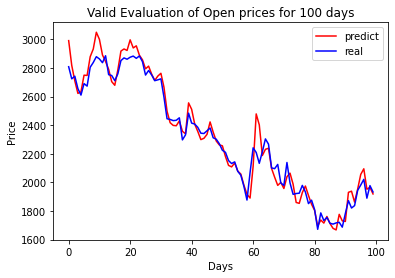

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 90.7685500587805
MAPE on validation set is -1.9600550121299458
MBE on validation set is -55.55819381693256
Up and down accuracy on validation set is 50.0%


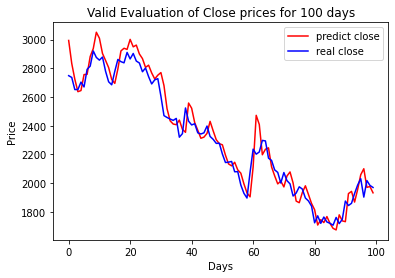

In [ ]:
evaluate(y_pred, valid_label, data_gainer)

##Attention layer

In [ ]:
_, loss_mean_attention = train(train_x, train_y, config, True)

Start training ...
Epoch 1/50  Train Loss :0.9263387412917036
Epoch 2/50  Train Loss :0.8462696100807569
Epoch 3/50  Train Loss :0.3769305650832882
Epoch 4/50  Train Loss :0.12642144046049678
Epoch 5/50  Train Loss :0.08402148719161137
Epoch 6/50  Train Loss :0.06425671266572577
Epoch 7/50  Train Loss :0.053705822931838905
Epoch 8/50  Train Loss :0.04722694639957496
Epoch 9/50  Train Loss :0.04717387380113186
Epoch 10/50  Train Loss :0.07507693062279262
Epoch 11/50  Train Loss :0.06393458536016379
Epoch 12/50  Train Loss :0.07685150881124132
Epoch 13/50  Train Loss :0.04148747623244773
Epoch 14/50  Train Loss :0.037123759767151814
Epoch 15/50  Train Loss :0.02480956886064456
Epoch 16/50  Train Loss :0.025546627427597265
Epoch 17/50  Train Loss :0.019736358870703505
Epoch 18/50  Train Loss :0.024024295153221423
Epoch 19/50  Train Loss :0.020160749858703964
Epoch 20/50  Train Loss :0.028163530544113757
Epoch 21/50  Train Loss :0.02412214813364753
Epoch 22/50  Train Loss :0.03441808739183

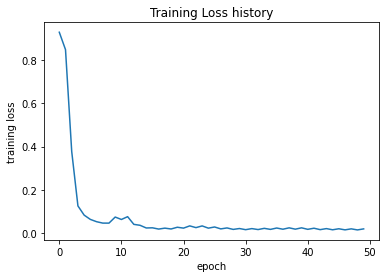

In [ ]:
loss_plot(loss_mean_attention)

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 153.03903551283886
MAPE on validation set is 0.28654898057013856
MBE on validation set is 14.56832076453811
Up and down accuracy on validation set is 52.0%


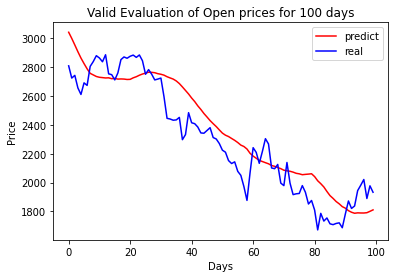

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 154.2358415718926
MAPE on validation set is 0.05735101011187119
MBE on validation set is 8.797825588519828
Up and down accuracy on validation set is 52.0%


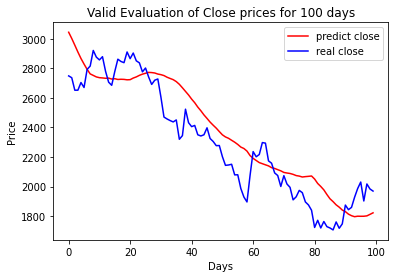

In [ ]:
y_pred_attention = predict(valid_x, config, True)
evaluate(y_pred_attention, valid_label, data_gainer)

## 3. Parameter Tuning

Parameter tuning to increase performaces on the valid set

In [ ]:
class Config_Tuning():
    def __init__(self, hidden_size=128, time_step=20, lstm_layers=2, learning_rate=0.0001, 
                 epoch=50, batch_size=64, label_columns=[1,4], feature_start=1, feature_end=7,
                 data_path="/content/stock_data.csv"):
    
        self.feature_columns = list(range(feature_start, feature_end))  # feature columns' indecies 
        self.label_columns = label_columns                # predicted feature columns' indecies
        self.label_in_feature_index = (lambda x,y: [x.index(i) for i in y])(self.feature_columns, self.label_columns)  
        
        self.predict_day = 1             # predited length (days)
        
        self.input_size = len(self.feature_columns)
        self.output_size = len(self.label_columns)

        self.hidden_size = hidden_size   # hiddent size
        self.lstm_layers = lstm_layers             # stacked layer number
        self.dropout_rate = 0.2          # dropout
        self.time_step = time_step       # step size (day)
        self.epoch = epoch
        self.epoch_attention = 50
        
    #     do_train = True
    #     do_predict = True
    #     shuffle_train_data = True           

        self.train_data_rate = 0.7      
        self.valid_data_rate = 0.075   
        self.test_data_rate = 0.075

        self.batch_size = batch_size
        self.learning_rate = learning_rate

        self.use_cuda = False
        # path
        self.used_frame = "pytorch"
        self.model_name = "model_" + ".pth"
        self.train_data_path = data_path
        self.model_save_path = "./checkpoint/" + self.used_frame + "/"
        
    def make_directions(self):
        # save 
        if not os.path.exists(self.model_save_path):
            os.makedirs(self.model_save_path)    

(1) Time Step

In [ ]:
config_tuning = Config_Tuning(time_step=20)
config_tuning.make_directions()

In [ ]:
_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)

In [ ]:
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer)

(2) Hidden Size

In [ ]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20)
config_tuning.make_directions()
_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer)

(3) LSTM Layers

In [ ]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20, lstm_layers=1)
config_tuning.make_directions()
_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer)

(4) Learning Rate

In [ ]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20, lstm_layers=1, learning_rate = 0.00005, epoch=200)
config_tuning.make_directions()
_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer)

In [ ]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20, lstm_layers=2, learning_rate = 0.00005, epoch=200)
config_tuning.make_directions()

_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer)

In [ ]:
evaluate(y_pred, valid_label, data_gainer, days=100)

(4)* Feature dimension

In [ ]:
config_tuning_open = Config_Tuning(hidden_size=32, time_step=20, lstm_layers=2, 
                              learning_rate = 0.01, epoch=100, batch_size=1500, 
                              label_columns=[2], feature_start=2, feature_end=6)
config_tuning_open.make_directions()
data_gainer = Data(config_tuning_open)
train_x, train_y = data_gainer.get_train_data()
valid_x, valid_y = data_gainer.get_valid_data()
test_x= data_gainer.get_test_data()
train_label = data_gainer.return_label("train")
valid_label = data_gainer.return_label("valid")
test_label = data_gainer.return_label("test")

Start training ...
Epoch 1/100  Train Loss :1.071210006872813
Epoch 2/100  Train Loss :0.6117202738920847
Epoch 3/100  Train Loss :0.35368632276852924
Epoch 4/100  Train Loss :0.21895050754149756
Epoch 5/100  Train Loss :0.215257927775383
Epoch 6/100  Train Loss :0.1311748909453551
Epoch 7/100  Train Loss :0.08379337812463443
Epoch 8/100  Train Loss :0.06732999254018068
Epoch 9/100  Train Loss :0.055590792248646416
Epoch 10/100  Train Loss :0.042798303067684174
Epoch 11/100  Train Loss :0.04503016887853543
Epoch 12/100  Train Loss :0.031019122029344242
Epoch 13/100  Train Loss :0.031748037009189524
Epoch 14/100  Train Loss :0.02548229678844412
Epoch 15/100  Train Loss :0.025959656573832035
Epoch 16/100  Train Loss :0.023150190400580566
Epoch 17/100  Train Loss :0.021483473324527342
Epoch 18/100  Train Loss :0.02042645200466116
Epoch 19/100  Train Loss :0.01874700530121724
Epoch 20/100  Train Loss :0.018272438397010166
Epoch 21/100  Train Loss :0.017115518916398287
Epoch 22/100  Train L

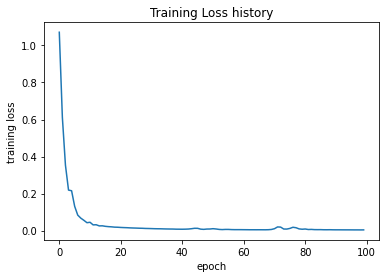

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 45.07432994399194
MAPE on validation set is -1.021631664511673
MBE on validation set is -27.998317001993566
Up and down accuracy on validation set is 67.0%


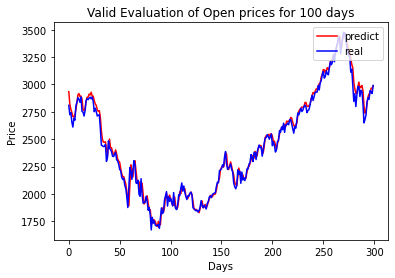

In [ ]:
_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer)

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 45.07432994399194
MAPE on validation set is -1.021631664511673
MBE on validation set is -27.998317001993566
Up and down accuracy on validation set is 67.0%


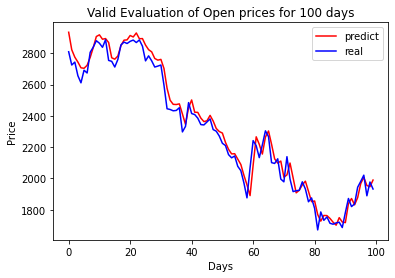

In [ ]:
evaluate(y_pred, valid_label, data_gainer, days=100)

(5) Batch Size

In [ ]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20, lstm_layers=2, 
                              learning_rate = 0.01, epoch=100, batch_size=1500)
config_tuning.make_directions()

_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer)
evaluate(y_pred, valid_label, data_gainer, days=100)

(6) Best Parameters

Start training ...
Epoch 1/200  Train Loss :0.9681844821950393
Epoch 2/200  Train Loss :0.8991105916506764
Epoch 3/200  Train Loss :0.8126104471843634
Epoch 4/200  Train Loss :0.679681196065147
Epoch 5/200  Train Loss :0.5309891996543799
Epoch 6/200  Train Loss :0.44042123762418084
Epoch 7/200  Train Loss :0.369421753643164
Epoch 8/200  Train Loss :0.3001228443889031
Epoch 9/200  Train Loss :0.2476428497249066
Epoch 10/200  Train Loss :0.21625746851230956
Epoch 11/200  Train Loss :0.19883595413611785
Epoch 12/200  Train Loss :0.18732527221566928
Epoch 13/200  Train Loss :0.17790230540836702
Epoch 14/200  Train Loss :0.16961770421311037
Epoch 15/200  Train Loss :0.1615405142335082
Epoch 16/200  Train Loss :0.15424183307827186
Epoch 17/200  Train Loss :0.14702179044512892
Epoch 18/200  Train Loss :0.13987678613291302
Epoch 19/200  Train Loss :0.1333740021539991
Epoch 20/200  Train Loss :0.12715603112340418
Epoch 21/200  Train Loss :0.12096527590652678
Epoch 22/200  Train Loss :0.11485643

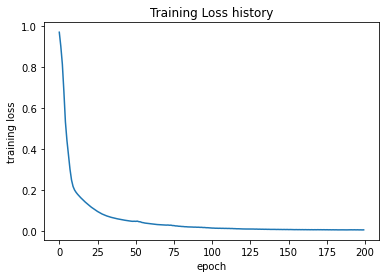

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 38.13967927417033
MAPE on validation set is 0.2893300183325158
MBE on validation set is 8.452167353920961
Up and down accuracy on validation set is 73.0%


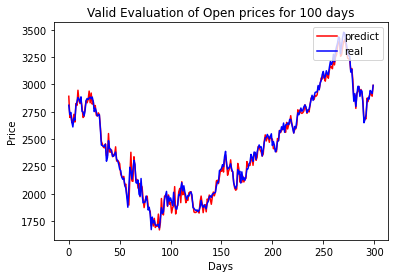

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 58.582295881474494
MAPE on validation set is -0.15818683020276794
MBE on validation set is -3.2581096575734083
Up and down accuracy on validation set is 49.0%


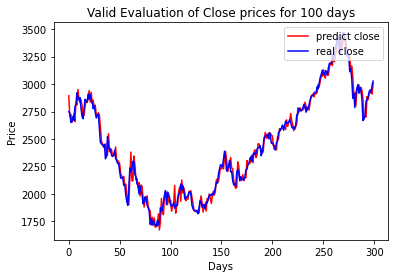

In [ ]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20, lstm_layers=2, 
                              learning_rate = 0.00005, epoch=200)
config_tuning.make_directions()

_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)


y_pred_valid = predict(valid_x, config_tuning)
evaluate(y_pred_valid, valid_label, data_gainer)

## Testing

## AAPL

Model Parameters:

* Hidden Size: 10
* Time Step: 20
* LSTM Layers: 2
* Learning Rate: 0.00005
* Eopch: 200

Start training ...
Epoch 1/200  Train Loss :0.23721436334244156
Epoch 2/200  Train Loss :0.07141857534441926
Epoch 3/200  Train Loss :0.034732161534078626
Epoch 4/200  Train Loss :0.027838309620156747
Epoch 5/200  Train Loss :0.023047624027715364
Epoch 6/200  Train Loss :0.019664649236434642
Epoch 7/200  Train Loss :0.017208491921971696
Epoch 8/200  Train Loss :0.015337194222102472
Epoch 9/200  Train Loss :0.013800409934355305
Epoch 10/200  Train Loss :0.012481692165922407
Epoch 11/200  Train Loss :0.011375745463637857
Epoch 12/200  Train Loss :0.010368679269909038
Epoch 13/200  Train Loss :0.009478469110102555
Epoch 14/200  Train Loss :0.008679440766231183
Epoch 15/200  Train Loss :0.007940764090370967
Epoch 16/200  Train Loss :0.007294336929831893
Epoch 17/200  Train Loss :0.006684897181261844
Epoch 18/200  Train Loss :0.006136537939651843
Epoch 19/200  Train Loss :0.00559177012140051
Epoch 20/200  Train Loss :0.005127386160092343
Epoch 21/200  Train Loss :0.004682545964563385
Epoch 

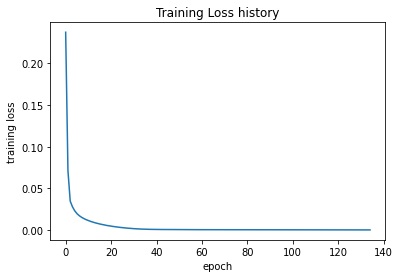

In [ ]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20, lstm_layers=2, 
                              learning_rate = 0.00005, epoch=200, 
                              data_path='/content/AAPL.csv')
config_tuning.make_directions()

_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)

###############################################################
Evaluation of open price predction on test set:
RMSE on validation set is 1.6508874255487753
MAPE on validation set is 1.8717816047843747
MBE on validation set is 0.9322377731887203
Up and down accuracy on validation set is 55.0%


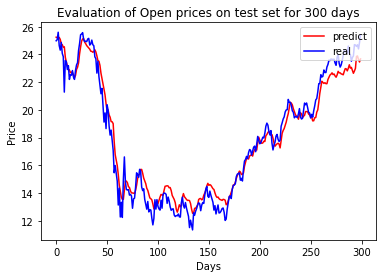

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 1.313523460056652
MAPE on validation set is 0.6911955900470632%
MBE on validation set is 0.49863224131315687
Up and down accuracy on validation set is 50.0%


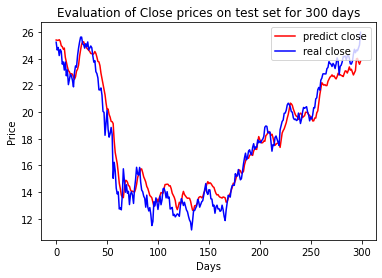

In [ ]:
y_pred_valid = predict(valid_x, config_tuning)
evaluate(y_pred_valid, valid_label, data_gainer)

## AMZN

Start training ...
Epoch 1/200  Train Loss :0.3014800973709614
Epoch 2/200  Train Loss :0.22208868236177498
Epoch 3/200  Train Loss :0.09210933239332267
Epoch 4/200  Train Loss :0.05053729901001567
Epoch 5/200  Train Loss :0.04591576953137678
Epoch 6/200  Train Loss :0.04188698799245887
Epoch 7/200  Train Loss :0.03838084658814801
Epoch 8/200  Train Loss :0.03530500693217156
Epoch 9/200  Train Loss :0.032514225898517504
Epoch 10/200  Train Loss :0.030120275323353117
Epoch 11/200  Train Loss :0.027991570428841643
Epoch 12/200  Train Loss :0.026114203094963043
Epoch 13/200  Train Loss :0.02448227365929929
Epoch 14/200  Train Loss :0.02301563878381063
Epoch 15/200  Train Loss :0.021695590267578762
Epoch 16/200  Train Loss :0.02047376891982461
Epoch 17/200  Train Loss :0.01934968659447299
Epoch 18/200  Train Loss :0.018297427289542697
Epoch 19/200  Train Loss :0.01729112329878031
Epoch 20/200  Train Loss :0.016353182413334413
Epoch 21/200  Train Loss :0.015469438056387598
Epoch 22/200  Tra

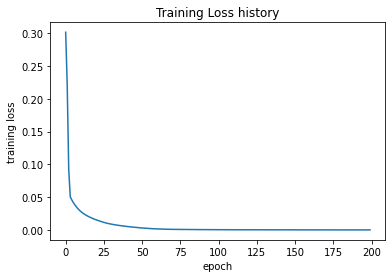

In [ ]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20, lstm_layers=2, 
                              learning_rate = 0.00005, epoch=200, 
                              data_path='/content/AMZN.csv')
config_tuning.make_directions()

data_gainer = Data(config_tuning)
train_x, train_y = data_gainer.get_train_data()
valid_x, valid_y = data_gainer.get_valid_data()
test_x= data_gainer.get_test_data()
train_label = data_gainer.return_label("train")
valid_label = data_gainer.return_label("valid")
test_label = data_gainer.return_label("test")

_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)

###############################################################
Evaluation of open price predction on test set:
RMSE on validation set is 7.631194278768716
MAPE on validation set is 0.5141562875727337
MBE on validation set is 1.9153594912262475
Up and down accuracy on validation set is 61.0%


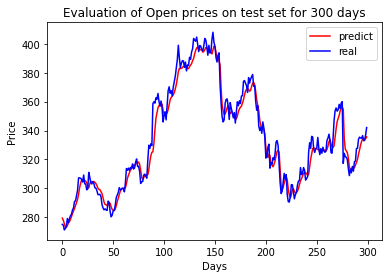

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 9.104975320991906
MAPE on validation set is -0.4504628530436646%
MBE on validation set is -1.2041006313998264
Up and down accuracy on validation set is 51.0%


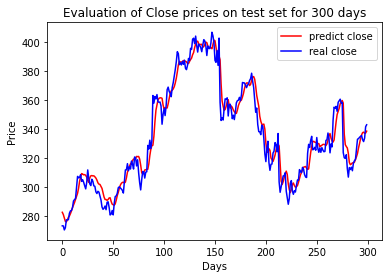

In [ ]:
y_pred_valid = predict(valid_x, config_tuning)
evaluate(y_pred_valid, valid_label, data_gainer)

## FB

Start training ...
Epoch 1/300  Train Loss :0.778458870397034
Epoch 2/300  Train Loss :0.7542843426662412
Epoch 3/300  Train Loss :0.7318329022435303
Epoch 4/300  Train Loss :0.7062638255936856
Epoch 5/300  Train Loss :0.6750954664735631
Epoch 6/300  Train Loss :0.6347889150069519
Epoch 7/300  Train Loss :0.5797596928578886
Epoch 8/300  Train Loss :0.5020089983008802
Epoch 9/300  Train Loss :0.39677438008683646
Epoch 10/300  Train Loss :0.29283960730853403
Epoch 11/300  Train Loss :0.24789983626793732
Epoch 12/300  Train Loss :0.23454838737168096
Epoch 13/300  Train Loss :0.2245947432450273
Epoch 14/300  Train Loss :0.21541966836560855
Epoch 15/300  Train Loss :0.20609414543617854
Epoch 16/300  Train Loss :0.1968179800632325
Epoch 17/300  Train Loss :0.18725893218916925
Epoch 18/300  Train Loss :0.1777444277805361
Epoch 19/300  Train Loss :0.1684220344759524
Epoch 20/300  Train Loss :0.1588811001486399
Epoch 21/300  Train Loss :0.15014338146217845
Epoch 22/300  Train Loss :0.1416367567

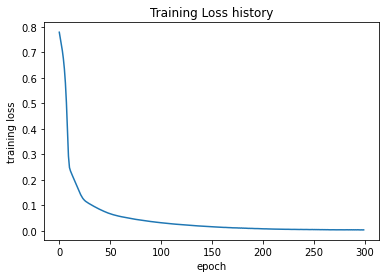

In [ ]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20, lstm_layers=2, 
                              learning_rate = 0.00005, epoch=300, 
                              data_path='/content/FB.csv')
config_tuning.make_directions()

data_gainer = Data(config_tuning)
train_x, train_y = data_gainer.get_train_data()
valid_x, valid_y = data_gainer.get_valid_data()
test_x= data_gainer.get_test_data()
train_label = data_gainer.return_label("train")
valid_label = data_gainer.return_label("valid")
test_label = data_gainer.return_label("test")

_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)

###############################################################
Evaluation of open price predction on test set:
RMSE on validation set is 3.52385785740282
MAPE on validation set is -0.41110197420132094
MBE on validation set is -0.6201094406891359
Up and down accuracy on validation set is 61.0%


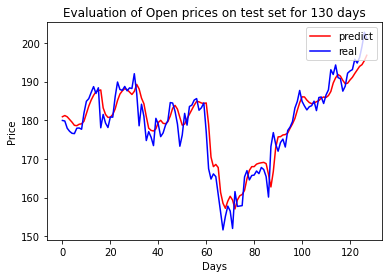

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 4.593479869444739
MAPE on validation set is -1.239497850957494%
MBE on validation set is -2.07463599892281
Up and down accuracy on validation set is 45.0%


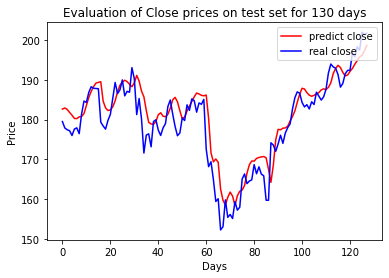

In [ ]:
y_pred_valid = predict(valid_x, config_tuning)
evaluate(y_pred_valid, valid_label, data_gainer)

## Trading Strategy

In [ ]:
class Portfolio:
    def __init__(self, open_pre, close_pre, open_true, close_true, period=100):
        self.open_pre = open_pre
        self.open_true = open_true
        self.close_pre = close_pre
        self.close_true = close_true
        self.period = period

    def long(self):
        money = 1000000
        days = 0
        l = []
        for i in range(self.period):
            if money <= 0:
                break
            o1, c1 = self.open_pre[i], self.close_pre[i]
            o2, c2 = self.open_true[i], self.close_true[i]
            days += 1
            if o1 >= c1:
                # cost = (money//o2)*o2
                # rev = (money//o2)*(c2-o2)
                # money += rev-cost
                purchase_money = money / 2
                money -= purchase_money
                num = purchase_money // o2
                change = purchase_money % o2
                money += num * (c2 - o2) + change
            l.append(money)
        return round(money/1000, 2), days, money, l

    def short(self):
        money = 1000
        hold = 50
        for i in range(self.period):
            o1, c1 = self.open_pre[i], self.close_pre[i]
            o2, c2 = self.open_true[i], self.close_true[i]
            if o1 < c1:
                cost = (money//o1)*o1
                rev = (money//o1)*(c2-o2) + hold*(c2-o2)
                money += rev-cost
                hold = 0
            elif o1 > c1 and hold > 0:
                money += hold*(o2-c2)
        return round(money/1000, 2)

In [ ]:
print(y_pred_valid[0, 0], y_pred_valid[0, 1], valid_label[0, 0], valid_label[0, 1])

print(y_pred_valid[1, 0], y_pred_valid[1, 1], valid_label[1, 0], valid_label[1, 1])

print(y_pred_valid[2, 0], y_pred_valid[2, 1], valid_label[2, 0], valid_label[2, 1])

1.1321966648101807 1.137487530708313 179.9499969482422 179.50999450683594
1.1416161060333252 1.1462270021438599 179.80999755859375 177.88999938964844
1.1447324752807617 1.1497081518173218 177.94000244140625 177.4499969482422


In [ ]:
portfolio = Portfolio(y_pred_valid[:, 0], y_pred_valid[:, 1], valid_label[:, 0], valid_label[:, 1], period=30)
# short = portfolio.short()
long_, days, money, l = portfolio.long()
# print(short)
print(long_, days, money)
print(l)

4.19 30 4186.857971191406
[1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 496626.2438964844, 245111.36389160156, 124619.96139526367, 64905.24850463867, 32037.087615966797, 15759.52767944336, 8094.527526855469, 4186.857971191406]
